In [1]:
# ML-topography Notebook - IOL Calculation for FacoDMEK Eyes
# This notebook evaluates SRK/T accuracy accounting for surgeon's IOL choice

# %% Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# %% Cell 2: Load and Explore Data
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

First few rows:


,ID,Patient,Eye,Sex,Birthdate,PreOP Diagnosis,Date of Surgery,Age,PostOP BCVA,PostOP Spherical Equivalent,...,CCT,Keratometric Km,Keratometric Ks,Keratometric Kf,Anterior Km,Anterior Ks,Anterior Kf,Posterior Km,Posterior Ks,Posterior Kf
0,1,facchin stefano,OS,M,1954-06-01,Fuchs,2021-12-01,67,1,-1.250,...,594,45.70,46.5,44.9,50.9,51.8,50.0,-6.45,-6.7,-6.2
1,2,alberghina andrea,OD,M,1967-06-01,Fuchs,2021-02-03,53,0.6,-3.125,...,699,47.20,48.0,46.4,52.6,53.5,51.7,-6.60,-6.8,-6.4
2,3,ardini adriana,OS,F,1951-06-01,Fuchs,2020-06-24,69,0.9,0.500,...,663,40.70,40.9,40.5,45.3,45.5,45.1,-6.60,-6.9,-6.3
3,4,Attaccalite vincenzo,OS,M,1947-06-01,Fuchs,2021-09-29,74,0.9,-0.750,...,526,43.25,43.5,43.0,48.2,48.5,47.9,-5.60,-5.7,-5.5
4,5,bisi anna maria,OD,F,1941-06-01,Fuchs,2020-10-28,79,0.8,-0.250,...,603,43.70,44.6,42.8,48.7,49.7,47.7,-5.80,-5.9,-5.7


In [3]:
# %% Cell 3: Data Preprocessing - Initial Setup
# Calculate average keratometry from KERATOMETRY (not biometry)
df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2

# Feature engineering for keratometry-based analysis
df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']

# First, we need to calculate SRK/T predictions before we can use them
# We'll calculate the errors after we have SRKT_Prediction in Cell 4

# Display summary statistics
print("Summary of key variables (before SRK/T calculation):")
print(df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 'PostOP Spherical Equivalent', 
          'CCT', 'Posterior Km']].describe())

# Check for missing values
print("\nMissing values in key columns:")
missing_counts = df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'CCT', 
                     'A-Constant', 'Posterior Km']].isnull().sum()
print(missing_counts)

# Count complete cases for SRK/T calculation
complete_cases = df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'A-Constant']].notna().all(axis=1).sum()
print(f"\nComplete cases for analysis: {complete_cases} out of {len(df)}")

Summary of key variables (before SRK/T calculation):
          Bio-AL  K_avg_Kerato  IOL Power  PostOP Spherical Equivalent  \
count  97.000000     97.000000  97.000000                    97.000000   
mean   23.831753     43.596907  21.463918                    -0.159794   
std     1.375736      1.876164   4.117574                     1.347348   
min    21.170000     39.050000  11.000000                    -3.875000   
25%    22.930000     42.400000  19.000000                    -1.000000   
50%    23.640000     43.700000  22.000000                     0.000000   
75%    24.590000     45.000000  24.000000                     0.500000   
max    28.230000     47.350000  30.000000                     5.000000   

              CCT  Posterior Km  
count   97.000000     97.000000  
mean   620.567010     -5.821134  
std     79.396278      0.386277  
min    448.000000     -6.700000  
25%    568.000000     -6.050000  
50%    606.000000     -5.750000  
75%    657.000000     -5.600000  
max    8

In [4]:
# %% Cell 4: Implement SRK/T Formula with Keratometry K Values
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """
    Calculate IOL power using SRK/T formula
    Uses keratometry K values
    Returns NaN if inputs are invalid
    """
    # Check for valid inputs
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        # Constants
        na = 1.336
        V = 12
        
        # Corneal radius from keratometry K
        r = 337.5 / K
        
        # Axial length correction
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Corneal width
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        # Check if we can calculate H (avoid negative square root)
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        # Corneal height
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # ACD constant from A-constant
        ACDconst = 0.62467 * A_const - 68.747
        
        # Offset
        offset = ACDconst - 3.336
        
        # Estimated postoperative ACD
        ACDest = H + offset
        
        # Retinal thickness correction
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        # Calculate IOL power for emmetropia
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Calculate SRK/T predictions
df['SRKT_Prediction'] = df.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']), 
    axis=1
)

# NOW we can calculate the errors with the CORRECT approach
# CRITICAL: Calculate expected spherical equivalent based on surgeon's choice
# If surgeon implants less than SRK/T prediction, patient will be more hyperopic
df['Expected_SE'] = -(df['IOL Power'] - df['SRKT_Prediction'])

# CORRECT ERROR CALCULATION: 
# Error is the difference between actual and expected spherical equivalent
df['SRKT_Error'] = df['PostOP Spherical Equivalent'] - df['Expected_SE']

# Show example calculations to verify logic
print("\nExample calculations:")
print("="*80)
example_df = df[['SRKT_Prediction', 'IOL Power', 'PostOP Spherical Equivalent', 
                 'Expected_SE', 'SRKT_Error']].head(10)
print(example_df)
print("\nInterpretation:")
print("- Expected_SE = -(IOL_Power - SRKT_Prediction)")
print("- If IOL < SRKT, Expected_SE is positive (hyperopic)")
print("- Error = Actual_SE - Expected_SE")

# Remove rows with NaN errors for analysis
valid_cases = df['SRKT_Error'].notna()

print("SRK/T Performance:")
print(f"Valid predictions: {valid_cases.sum()} out of {len(df)}")
if valid_cases.sum() > 0:
    print(f"Mean Error: {df.loc[valid_cases, 'SRKT_Error'].mean():.3f} D")
    print(f"Mean Absolute Error: {df.loc[valid_cases, 'SRKT_Error'].abs().mean():.3f} D")
    print(f"Standard Deviation: {df.loc[valid_cases, 'SRKT_Error'].std():.3f} D")



Example calculations:
   SRKT_Prediction  IOL Power  PostOP Spherical Equivalent  Expected_SE  \
0         8.222235       12.0                       -1.250    -3.777765   
1        16.374094       15.0                       -3.125     1.374094   
2        25.153968       22.0                        0.500     3.153968   
3        18.607376       20.0                       -0.750    -1.392624   
4        16.733835       17.5                       -0.250    -0.766165   
5        24.005288       25.0                        0.000    -0.994712   
6        22.812998       24.0                        0.000    -1.187002   
7        23.143574       24.0                        0.750    -0.856426   
8        13.733996       17.0                       -1.000    -3.266004   
9        27.380438       28.0                        0.000    -0.619562   

   SRKT_Error  
0    2.527765  
1   -4.499094  
2   -2.653968  
3    0.642624  
4    0.516165  
5    0.994712  
6    1.187002  
7    1.606426  
8    2.

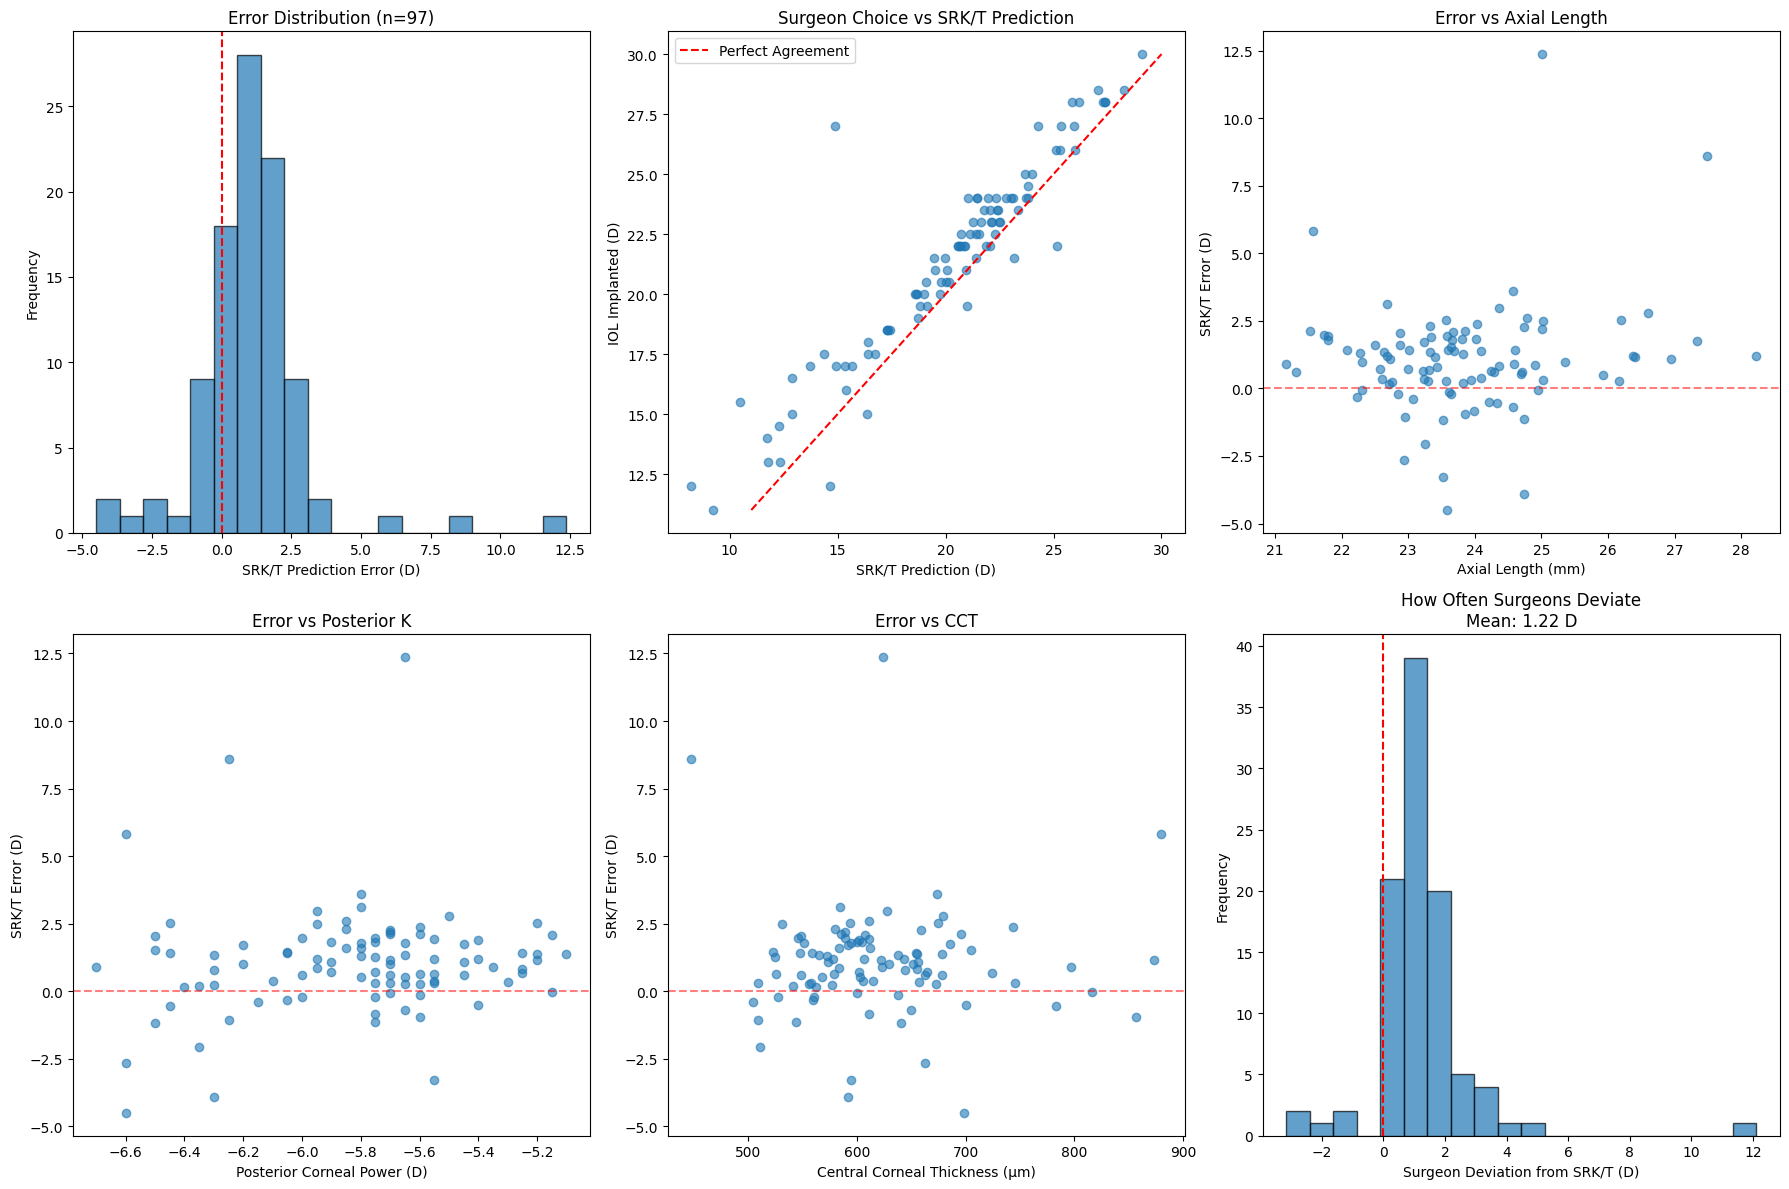


Percentage of eyes within target:
±0.25 D: 8.2%
±0.50 D: 18.6%
±1.00 D: 41.2%


In [5]:
# %% Cell 5: Visualize SRK/T Performance
# Only plot for rows with valid data
df_valid = df[df['SRKT_Error'].notna()].copy()

if len(df_valid) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Error Distribution
    axes[0, 0].hist(df_valid['SRKT_Error'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('SRK/T Prediction Error (D)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Error Distribution (n={len(df_valid)})')

    # Plot 2: Surgeon's Choice vs SRK/T Prediction
    axes[0, 1].scatter(df_valid['SRKT_Prediction'], df_valid['IOL Power'], alpha=0.6)
    axes[0, 1].plot([df_valid['IOL Power'].min(), df_valid['IOL Power'].max()], 
                    [df_valid['IOL Power'].min(), df_valid['IOL Power'].max()], 'r--', label='Perfect Agreement')
    axes[0, 1].set_xlabel('SRK/T Prediction (D)')
    axes[0, 1].set_ylabel('IOL Implanted (D)')
    axes[0, 1].set_title('Surgeon Choice vs SRK/T Prediction')
    axes[0, 1].legend()

    # Plot 3: Error vs Axial Length
    axes[0, 2].scatter(df_valid['Bio-AL'], df_valid['SRKT_Error'], alpha=0.6)
    axes[0, 2].set_xlabel('Axial Length (mm)')
    axes[0, 2].set_ylabel('SRK/T Error (D)')
    axes[0, 2].set_title('Error vs Axial Length')
    axes[0, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 4: Error vs Posterior Corneal Power
    axes[1, 0].scatter(df_valid['Posterior Km'], df_valid['SRKT_Error'], alpha=0.6)
    axes[1, 0].set_xlabel('Posterior Corneal Power (D)')
    axes[1, 0].set_ylabel('SRK/T Error (D)')
    axes[1, 0].set_title('Error vs Posterior K')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 5: Error vs CCT
    valid_cct = df_valid[df_valid['CCT'].notna()]
    axes[1, 1].scatter(valid_cct['CCT'], valid_cct['SRKT_Error'], alpha=0.6)
    axes[1, 1].set_xlabel('Central Corneal Thickness (μm)')
    axes[1, 1].set_ylabel('SRK/T Error (D)')
    axes[1, 1].set_title('Error vs CCT')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 6: Surgeon Deviation Distribution
    surgeon_deviation = df_valid['IOL Power'] - df_valid['SRKT_Prediction']
    axes[1, 2].hist(surgeon_deviation, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 2].axvline(x=0, color='red', linestyle='--')
    axes[1, 2].set_xlabel('Surgeon Deviation from SRK/T (D)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'How Often Surgeons Deviate\nMean: {surgeon_deviation.mean():.2f} D')

    plt.tight_layout()
    plt.show()

    # Calculate percentage within target ranges
    within_025 = (df_valid['SRKT_Error'].abs() <= 0.25).sum() / len(df_valid) * 100
    within_050 = (df_valid['SRKT_Error'].abs() <= 0.50).sum() / len(df_valid) * 100
    within_100 = (df_valid['SRKT_Error'].abs() <= 1.00).sum() / len(df_valid) * 100
    
    print(f"\nPercentage of eyes within target:")
    print(f"±0.25 D: {within_025:.1f}%")
    print(f"±0.50 D: {within_050:.1f}%")
    print(f"±1.00 D: {within_100:.1f}%")
else:
    print("No valid cases for visualization")

In [6]:
# %% Cell 6: Analysis of When Surgeons Deviate from SRK/T
print("\nANALYSIS: When and Why Surgeons Deviate from SRK/T")
print("="*60)

# Only analyze cases where we have valid SRK/T predictions
df_analysis = df[df['SRKT_Error'].notna()].copy()

if len(df_analysis) > 0:
    # Calculate surgeon deviation
    df_analysis['Surgeon_Deviation'] = df_analysis['IOL Power'] - df_analysis['SRKT_Prediction']

    # Group by deviation patterns
    print("Surgeon Deviation Patterns:")
    print(f"Mean deviation: {df_analysis['Surgeon_Deviation'].mean():.3f} D")
    print(f"Std deviation: {df_analysis['Surgeon_Deviation'].std():.3f} D")

    # Analyze when surgeons deviate more
    print("\nCorrelation of Surgeon Deviation with Eye Parameters:")
    correlations = df_analysis[['Surgeon_Deviation', 'Bio-AL', 'K_avg_Kerato', 
                               'Posterior Km', 'CCT', 'K_Astigmatism_Kerato']].corr()['Surgeon_Deviation'].sort_values()
    print(correlations)

    # Group eyes by axial length
    df_analysis['AL_group'] = pd.cut(df_analysis['Bio-AL'], 
                                     bins=[0, 22, 24, 26, 100], 
                                     labels=['Short', 'Normal', 'Long', 'Very Long'])

    print("\nSurgeon Deviation by Axial Length Group:")
    deviation_by_al = df_analysis.groupby('AL_group')['Surgeon_Deviation'].agg(['mean', 'std', 'count'])
    print(deviation_by_al)
else:
    print("No valid cases for analysis")


ANALYSIS: When and Why Surgeons Deviate from SRK/T
Surgeon Deviation Patterns:
Mean deviation: 1.222 D
Std deviation: 1.609 D

Correlation of Surgeon Deviation with Eye Parameters:
CCT                     0.015901
Posterior Km            0.093727
K_Astigmatism_Kerato    0.093998
K_avg_Kerato            0.131133
Bio-AL                  0.261346
Surgeon_Deviation       1.000000
Name: Surgeon_Deviation, dtype: float64

Surgeon Deviation by Axial Length Group:
               mean       std  count
AL_group                            
Short      1.116858  0.702230      7
Normal     0.897281  1.059758     53
Long       1.446192  2.356109     28
Very Long  2.515470  1.378598      9


In [7]:
# %% Cell 7: Optimize Corneal Refractive Index
# Only use complete cases
df_complete = df[df['SRKT_Error'].notna()].copy()

def objective_nc(nc_value):
    """Objective function to minimize MAE by optimizing nc"""
    predictions = df_complete.apply(
        lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant'], nc=nc_value[0]), 
        axis=1
    )
    # Recalculate expected SE and errors with new predictions
    expected_se = -(df_complete['IOL Power'] - predictions)
    errors = df_complete['PostOP Spherical Equivalent'] - expected_se
    # Remove any NaN values that might occur
    valid_errors = errors[errors.notna()]
    if len(valid_errors) == 0:
        return 999  # Return large value if no valid predictions
    return np.mean(np.abs(valid_errors))

# Optimize nc
if len(df_complete) > 0:
    result_nc = minimize(objective_nc, x0=[1.333], bounds=[(1.330, 1.340)], method='L-BFGS-B')
    optimal_nc = result_nc.x[0]
    
    # Recalculate with optimal nc
    df_complete['SRKT_Optimized_nc'] = df_complete.apply(
        lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant'], nc=optimal_nc), 
        axis=1
    )
    df_complete['Expected_SE_Optimized'] = -(df_complete['IOL Power'] - df_complete['SRKT_Optimized_nc'])
    df_complete['SRKT_Error_Optimized_nc'] = df_complete['PostOP Spherical Equivalent'] - df_complete['Expected_SE_Optimized']
    
    print(f"Optimal corneal refractive index: {optimal_nc:.4f}")
    print(f"Original MAE: {df_complete['SRKT_Error'].abs().mean():.3f} D")
    print(f"Optimized MAE: {df_complete['SRKT_Error_Optimized_nc'].abs().mean():.3f} D")
else:
    print("Not enough complete cases for optimization")


Optimal corneal refractive index: 1.3300
Original MAE: 1.571 D
Optimized MAE: 1.312 D


In [8]:
# %% Cell 8: Optimize SRK/T Formula Constants
print("\nOPTIMIZING SRK/T FORMULA CONSTANTS")
print("="*60)

# Start with the optimized nc
if 'optimal_nc' not in locals():
    optimal_nc = 1.3300  # Use the value you found

print(f"Starting with optimized nc: {optimal_nc:.4f}")

# Create an extended SRK/T function with adjustable constants
def calculate_SRKT_extended(AL, K, A_const, params):
    """
    Calculate IOL power using SRK/T formula with adjustable constants
    params = [nc, cw_const1, cw_const2, cw_const3, acd_const1, acd_const2, 
              offset_const, rethick_const1, rethick_const2, lcor_threshold]
    """
    # Unpack parameters
    nc = params[0]
    cw_const1, cw_const2, cw_const3 = params[1:4]
    acd_const1, acd_const2 = params[4:6]
    offset_const = params[6]
    rethick_const1, rethick_const2 = params[7:9]
    lcor_threshold = params[9]
    
    # Check for valid inputs
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        # Constants
        na = 1.336
        V = 12
        
        # Corneal radius from keratometry K
        r = 337.5 / K
        
        # Axial length correction with adjustable threshold
        if AL > lcor_threshold:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Corneal width with adjustable constants
        Cw = cw_const1 + cw_const2 * LCOR + cw_const3 * K
        
        # Check if we can calculate H
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        # Corneal height
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # ACD constant with adjustable parameters
        ACDconst = acd_const1 * A_const - acd_const2
        
        # Offset with adjustable constant
        offset = ACDconst - offset_const
        
        # Estimated postoperative ACD
        ACDest = H + offset
        
        # Retinal thickness correction with adjustable constants
        RETHICK = rethick_const1 - rethick_const2 * AL
        LOPT = AL + RETHICK
        
        # Calculate IOL power for emmetropia
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Prepare data for optimization
df_opt = df[df['SRKT_Error'].notna()].copy()

# Calculate true IOL for emmetropia
df_opt['True_IOL_for_Emmetropia'] = df_opt['IOL Power'] - df_opt['PostOP Spherical Equivalent']

# Objective function to minimize MAE
def objective_srkt_constants(params):
    """Minimize MAE by optimizing SRK/T constants"""
    predictions = df_opt.apply(
        lambda row: calculate_SRKT_extended(row['Bio-AL'], row['K_avg_Kerato'], 
                                           row['A-Constant'], params), 
        axis=1
    )
    
    # Calculate expected SE based on surgeon's choice
    expected_se = -(df_opt['IOL Power'] - predictions)
    errors = df_opt['PostOP Spherical Equivalent'] - expected_se
    
    # Remove NaN values
    valid_errors = errors[errors.notna()]
    if len(valid_errors) == 0:
        return 999
    
    return np.mean(np.abs(valid_errors))

# Initial parameters (standard SRK/T values)
initial_params = [
    optimal_nc,      # nc (already optimized)
    -5.41,          # cw_const1
    0.58412,        # cw_const2
    0.098,          # cw_const3
    0.62467,        # acd_const1
    68.747,         # acd_const2
    3.336,          # offset_const
    0.65696,        # rethick_const1
    0.02029,        # rethick_const2
    24.2            # lcor_threshold
]

# Bounds for optimization (allow ±20% variation for most constants)
bounds = [
    (optimal_nc, optimal_nc),  # Keep nc fixed at optimized value
    (-6.5, -4.3),             # cw_const1
    (0.47, 0.70),             # cw_const2
    (0.078, 0.118),           # cw_const3
    (0.50, 0.75),             # acd_const1
    (55.0, 82.0),             # acd_const2
    (2.7, 4.0),               # offset_const
    (0.52, 0.79),             # rethick_const1
    (0.016, 0.024),           # rethick_const2
    (23.0, 25.5)              # lcor_threshold
]

print("\nOptimizing SRK/T formula constants...")
print("This may take a few minutes...")

# Optimize
from scipy.optimize import differential_evolution

result = differential_evolution(objective_srkt_constants, bounds, 
                               maxiter=50, seed=42, workers=1,
                               disp=True, polish=True)

optimal_params = result.x

print(f"\nOptimization complete!")
print(f"Original MAE with optimized nc only: {objective_srkt_constants(initial_params):.3f} D")
print(f"Final MAE with all constants optimized: {result.fun:.3f} D")

# Show which constants changed the most
param_names = ['nc', 'cw_const1', 'cw_const2', 'cw_const3', 'acd_const1', 
               'acd_const2', 'offset_const', 'rethick_const1', 'rethick_const2', 
               'lcor_threshold']

print("\nOptimized constants (% change from original):")
for i, (name, orig, opt) in enumerate(zip(param_names, initial_params, optimal_params)):
    if i > 0:  # Skip nc as it was kept fixed
        pct_change = (opt - orig) / abs(orig) * 100
        print(f"{name}: {orig:.4f} → {opt:.4f} ({pct_change:+.1f}%)")

# Calculate predictions with optimized formula
df_opt['SRKT_Optimized'] = df_opt.apply(
    lambda row: calculate_SRKT_extended(row['Bio-AL'], row['K_avg_Kerato'], 
                                       row['A-Constant'], optimal_params), 
    axis=1
)

df_opt['Expected_SE_Optimized'] = -(df_opt['IOL Power'] - df_opt['SRKT_Optimized'])
df_opt['Error_Optimized'] = df_opt['PostOP Spherical Equivalent'] - df_opt['Expected_SE_Optimized']

print(f"\nFinal performance:")
print(f"MAE: {df_opt['Error_Optimized'].abs().mean():.3f} D")
print(f"Mean Error: {df_opt['Error_Optimized'].mean():.3f} D")
print(f"STD: {df_opt['Error_Optimized'].std():.3f} D")

# Save the optimized constants
optimized_constants_df = pd.DataFrame({
    'Constant': param_names,
    'Original': initial_params,
    'Optimized': optimal_params,
    'Change_%': [(opt - orig) / abs(orig) * 100 if i > 0 else 0 
                 for i, (orig, opt) in enumerate(zip(initial_params, optimal_params))]
})



OPTIMIZING SRK/T FORMULA CONSTANTS
Starting with optimized nc: 1.3300

Optimizing SRK/T formula constants...
This may take a few minutes...
differential_evolution step 1: f(x)= 1.2422622213226506
differential_evolution step 2: f(x)= 1.2422622213226506
differential_evolution step 3: f(x)= 1.2301868268758995
differential_evolution step 4: f(x)= 1.2278784464070966
differential_evolution step 5: f(x)= 1.2278784464070966
differential_evolution step 6: f(x)= 1.1997289305299126
differential_evolution step 7: f(x)= 1.1975259567293077
differential_evolution step 8: f(x)= 1.1975259567293077
differential_evolution step 9: f(x)= 1.1975259567293077
differential_evolution step 10: f(x)= 1.1975259567293077
differential_evolution step 11: f(x)= 1.1975259567293077
differential_evolution step 12: f(x)= 1.1374648376437018
differential_evolution step 13: f(x)= 1.1374648376437018
differential_evolution step 14: f(x)= 1.0957228777767067
differential_evolution step 15: f(x)= 1.0957228777767067
differential_

In [10]:
# %% Cell 9: Machine Learning to Further Optimize the Formula
if 'df_opt' in locals() and len(df_opt) > 10:
    print("\nUSING ML TO FURTHER OPTIMIZE THE FORMULA")
    print("="*60)
    
    # Now use ML to predict residual errors after constant optimization
    features_ml = ['Bio-AL', 'K_avg_Kerato', 'Posterior Km', 'CCT', 'Post_Ant_Ratio', 
                   'K_Astigmatism_Kerato', 'A-Constant']
    
    # Prepare data
    df_ml_opt = df_opt[features_ml + ['Error_Optimized', 'SRKT_Optimized', 
                                       'IOL Power', 'PostOP Spherical Equivalent']].dropna()
    X_ml = df_ml_opt[features_ml]
    
    # Target is the remaining error after optimization
    y_residual = df_ml_opt['Error_Optimized']
    
    print(f"Cases for ML refinement: {len(X_ml)}")
    print(f"Mean residual error after constant optimization: {y_residual.mean():.3f} D")
    print(f"STD of residual errors: {y_residual.std():.3f} D")
    
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
    }
    
    # Cross-validation results
    results = {}
    best_predictions = None
    best_mae = float('inf')
    
    for name, model in models.items():
        predictions = []
        actuals = []
        
        loo = LeaveOneOut()
        for train_idx, test_idx in loo.split(X_ml):
            X_train, X_test = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
            y_train, y_test = y_residual.iloc[train_idx], y_residual.iloc[test_idx]
            
            # Apply RobustScaler
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train model to predict residual error
            model.fit(X_train_scaled, y_train)
            residual_pred = model.predict(X_test_scaled)[0]
            
            # Get the optimized SRK/T prediction and actual values
            srkt_opt = df_ml_opt.iloc[test_idx]['SRKT_Optimized'].values[0]
            iol_implanted = df_ml_opt.iloc[test_idx]['IOL Power'].values[0]
            postop_se = df_ml_opt.iloc[test_idx]['PostOP Spherical Equivalent'].values[0]
            
            # Calculate expected SE with ML correction
            expected_se_base = -(iol_implanted - srkt_opt)
            expected_se_ml = expected_se_base + residual_pred
            
            predictions.append(expected_se_ml)
            actuals.append(postop_se)
        
        mae = mean_absolute_error(actuals, predictions)
        results[name] = mae
        
        if mae < best_mae:
            best_mae = mae
            best_predictions = predictions
        
        print(f"{name} MAE: {mae:.3f} D")
    
    # Compare improvements
    mae_constants_only = df_opt['Error_Optimized'].abs().mean()
    
    print(f"\nPerformance Summary:")
    print(f"Original SRK/T MAE: {df_opt['SRKT_Error'].abs().mean():.3f} D")
    print(f"With optimized constants: {mae_constants_only:.3f} D")
    print(f"With constants + ML: {min(results.values()):.3f} D")
    print(f"Total improvement: {df_opt['SRKT_Error'].abs().mean() - min(results.values()):.3f} D")
    
    # Store best predictions for plotting
    if best_predictions is not None:
        final_predictions_ml = best_predictions
        final_actuals_ml = actuals
else:
    print("Not enough data for ML refinement")


USING ML TO FURTHER OPTIMIZE THE FORMULA
Cases for ML refinement: 13
Mean residual error after constant optimization: -0.170 D
STD of residual errors: 1.012 D
Linear Regression MAE: 2.095 D
Ridge Regression MAE: 1.608 D
Random Forest MAE: 0.958 D
Gradient Boosting MAE: 1.264 D

Performance Summary:
Original SRK/T MAE: 1.571 D
With optimized constants: 0.669 D
With constants + ML: 0.958 D
Total improvement: 0.613 D


In [11]:
# %% Cell 10: Create Final Optimized Formula for FacoDMEK
if len(df_ml) > 10:
    # Create simplified correction formula based on key features
    top_features = ['Posterior Km', 'CCT', 'Bio-AL']
    
    # Ensure we have True IOL for emmetropia
    if 'True_IOL_for_Emmetropia' not in df_ml.columns:
        df_ml['True_IOL_for_Emmetropia'] = df_ml['IOL Power'] - df_ml['PostOP Spherical Equivalent']
    
    # Ensure we have complete data for these features
    df_simple = df_ml[top_features + ['SRKT_Prediction', 'True_IOL_for_Emmetropia', 
                                      'IOL Power', 'PostOP Spherical Equivalent']].dropna()
    X_simple = df_simple[top_features]
    
    # Target is IOL correction needed
    y_iol_correction = df_simple['True_IOL_for_Emmetropia'] - df_simple['SRKT_Prediction']
    
    # Scale the features
    scaler_simple = RobustScaler()
    X_simple_scaled = scaler_simple.fit_transform(X_simple)
    
    model_simple = LinearRegression()
    model_simple.fit(X_simple_scaled, y_iol_correction)
    
    # Get the scaling parameters for clinical use
    print(f"\nRobustScaler Parameters (for clinical implementation):")
    print(f"Medians: {scaler_simple.center_}")
    print(f"IQRs: {scaler_simple.scale_}")
    
    print(f"\nFacoDMEK IOL Correction Formula:")
    print(f"Step 1: Calculate standard SRK/T IOL prediction")
    print(f"Step 2: Scale features using RobustScaler")
    for i, feat in enumerate(top_features):
        print(f"  {feat}_scaled = ({feat} - {scaler_simple.center_[i]:.3f}) / {scaler_simple.scale_[i]:.3f}")
    
    print(f"\nStep 3: Calculate IOL correction")
    print(f"IOL_Correction = {model_simple.intercept_:.3f}")
    for feat, coef in zip(top_features, model_simple.coef_):
        print(f"                + {coef:.4f} × {feat}_scaled")
    
    print(f"\nStep 4: Corrected_IOL = SRK/T_IOL + IOL_Correction")
    print(f"\nThis gives the IOL power to implant for emmetropia in FacoDMEK eyes")
    
    # Test the formula with LOO
    loo = LeaveOneOut()
    final_predictions = []
    final_actuals = []
    
    for train_idx, test_idx in loo.split(df_simple):
        X_train = df_simple.iloc[train_idx][top_features]
        y_train = df_simple.iloc[train_idx]['True_IOL_for_Emmetropia'] - df_simple.iloc[train_idx]['SRKT_Prediction']
        
        # Fit scaler and model on training data
        scaler_cv = RobustScaler()
        X_train_scaled = scaler_cv.fit_transform(X_train)
        
        model_cv = LinearRegression()
        model_cv.fit(X_train_scaled, y_train)
        
        # Predict on test
        X_test = df_simple.iloc[test_idx][top_features]
        X_test_scaled = scaler_cv.transform(X_test.values.reshape(1, -1))
        iol_correction = model_cv.predict(X_test_scaled)[0]
        
        # Calculate final prediction
        test_row = df_simple.iloc[test_idx]
        corrected_iol = test_row['SRKT_Prediction'] + iol_correction
        
        # Expected SE based on what was actually implanted
        expected_se = -(test_row['IOL Power'] - corrected_iol)
        
        final_predictions.append(expected_se)
        final_actuals.append(test_row['PostOP Spherical Equivalent'])
    
    final_mae = mean_absolute_error(final_actuals, final_predictions)
    print(f"\nFinal formula MAE: {final_mae:.3f} D")
    
    # Also show the performance if the corrected IOL had been implanted
    iol_errors = []
    for i in range(len(df_simple)):
        test_row = df_simple.iloc[i]
        X_test = test_row[top_features].values.reshape(1, -1)
        X_test_scaled = scaler_simple.transform(X_test)
        iol_correction = model_simple.predict(X_test_scaled)[0]
        
        corrected_iol = test_row['SRKT_Prediction'] + iol_correction
        true_iol = test_row['True_IOL_for_Emmetropia']
        iol_errors.append(corrected_iol - true_iol)
    
    print(f"\nIOL prediction accuracy (if corrected IOL had been implanted):")
    print(f"Mean IOL error: {np.mean(iol_errors):.3f} D")
    print(f"Mean absolute IOL error: {np.mean(np.abs(iol_errors)):.3f} D")

NameError: name 'df_ml' is not defined

In [12]:
# %% Cell 11: Final Validation and Results Summary
if len(df_ml) > 10:
    # Summary statistics
    print("FINAL RESULTS SUMMARY")
    print("="*60)
    print(f"Original data points: {len(df)}")
    print(f"Complete cases for analysis: {len(df_ml)}")
    
    print(f"\nOriginal SRK/T Performance:")
    print(f"  MAE: {df_ml['SRKT_Error'].abs().mean():.3f} D")
    print(f"  Mean Error: {df_ml['SRKT_Error'].mean():.3f} D")
    print(f"  STD: {df_ml['SRKT_Error'].std():.3f} D")
    
    if 'optimal_nc' in locals():
        print(f"\nOptimized corneal refractive index: {optimal_nc:.4f}")
    
    print("\n" + "="*60)
    print("KEY INSIGHTS:")
    print("="*60)
    print("1. The error of SRK/T must account for the surgeon's deviation from the formula.")
    print("2. ML models should predict IOL corrections, not SE errors.")
    print("3. The corrected formula predicts which IOL to implant for emmetropia.")
    
    # Create visualization of improvement
    plt.figure(figsize=(12, 8))
    
    # Bland-Altman plot
    plt.subplot(2, 2, 1)
    # Use final predictions if available, otherwise use original errors
    if 'final_predictions' in locals() and 'final_actuals' in locals():
        mean_values = (np.array(final_predictions) + np.array(final_actuals)) / 2
        diff_values = np.array(final_predictions) - np.array(final_actuals)
    else:
        # Use original SRK/T errors for plotting
        mean_values = df_ml['PostOP Spherical Equivalent'].values
        diff_values = df_ml['SRKT_Error'].values
    
    plt.scatter(mean_values, diff_values, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='-', linewidth=2)
    plt.axhline(y=diff_values.mean(), color='blue', linestyle='--')
    plt.axhline(y=diff_values.mean() + 1.96*diff_values.std(), color='blue', linestyle=':')
    plt.axhline(y=diff_values.mean() - 1.96*diff_values.std(), color='blue', linestyle=':')
    
    plt.xlabel('Mean of Predicted and Actual SE (D)')
    plt.ylabel('Predicted - Actual SE (D)')
    plt.title('Bland-Altman Plot: Formula Performance')
    plt.grid(True, alpha=0.3)
    
    # Error distribution
    plt.subplot(2, 2, 2)
    plt.hist(df_ml['SRKT_Error'], bins=15, alpha=0.5, label='Original SRK/T', edgecolor='black')
    if 'diff_values' in locals():
        plt.hist(diff_values, bins=15, alpha=0.5, label='Optimized Formula', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Error (D)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    
    # IOL Correction vs Posterior K
    plt.subplot(2, 2, 3)
    # Ensure we have the data for plotting
    if 'top_features' not in locals():
        top_features = ['Posterior Km', 'CCT', 'Bio-AL']
    if 'df_simple' not in locals():
        df_simple = df_ml[top_features + ['SRKT_Prediction', 'True_IOL_for_Emmetropia']].dropna()
    if 'y_iol_correction' not in locals():
        y_iol_correction = df_simple['True_IOL_for_Emmetropia'] - df_simple['SRKT_Prediction']
    plt.scatter(df_simple['Posterior Km'], y_iol_correction, alpha=0.6)
    plt.xlabel('Posterior K (D)')
    plt.ylabel('IOL Correction Needed (D)')
    plt.title('IOL Correction vs Posterior K')
    plt.axhline(y=0, color='red', linestyle='--')
    
    # Feature importance
    plt.subplot(2, 2, 4)
    # Ensure we have the model and features
    if 'model_simple' not in locals() or 'scaler_simple' not in locals():
        # Recreate the model if needed
        if 'top_features' not in locals():
            top_features = ['Posterior Km', 'CCT', 'Bio-AL']
        if 'df_simple' not in locals():
            df_simple = df_ml[top_features + ['SRKT_Prediction', 'True_IOL_for_Emmetropia']].dropna()
        X_simple = df_simple[top_features]
        y_iol_correction = df_simple['True_IOL_for_Emmetropia'] - df_simple['SRKT_Prediction']
        scaler_simple = RobustScaler()
        X_simple_scaled = scaler_simple.fit_transform(X_simple)
        model_simple = LinearRegression()
        model_simple.fit(X_simple_scaled, y_iol_correction)
    
    importance_data = pd.DataFrame({
        'Feature': top_features,
        'Coefficient': model_simple.coef_,
        'Abs_Coefficient': np.abs(model_simple.coef_)
    }).sort_values('Abs_Coefficient', ascending=True)
    
    plt.barh(importance_data['Feature'], importance_data['Abs_Coefficient'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance for IOL Correction')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    # Ensure True_IOL_for_Emmetropia is calculated
    if 'True_IOL_for_Emmetropia' not in df_ml.columns:
        df_ml['True_IOL_for_Emmetropia'] = df_ml['IOL Power'] - df_ml['PostOP Spherical Equivalent']
    
    results_df = df_ml[['ID', 'Patient', 'Eye', 'Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                        'SRKT_Prediction', 'PostOP Spherical Equivalent', 'Expected_SE',
                        'SRKT_Error', 'Posterior Km', 'CCT']].copy()
    
    # Add the true IOL for emmetropia
    results_df['True_IOL_for_Emmetropia'] = results_df['IOL Power'] - results_df['PostOP Spherical Equivalent']
    results_df['SRKT_IOL_Error'] = results_df['SRKT_Prediction'] - results_df['True_IOL_for_Emmetropia']
    
    # Add scaling parameters to the Excel file
    scaling_params_df = pd.DataFrame({
        'Feature': top_features,
        'Median': scaler_simple.center_,
        'IQR': scaler_simple.scale_,
        'Coefficient': model_simple.coef_
    })
    
    # Add model performance summary
    performance_df = pd.DataFrame({
        'Model': ['Original SRK/T', 'Optimized nc', 'ML-Corrected Formula'],
        'MAE': [df_ml['SRKT_Error'].abs().mean(), 
                df_complete['SRKT_Error_Optimized_nc'].abs().mean() if 'df_complete' in locals() and 'optimal_nc' in locals() else np.nan,
                final_mae if 'final_mae' in locals() else np.nan]
    })
    
    # Save all dataframes to Excel
    with pd.ExcelWriter('FacoDMEK_Results.xlsx') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        scaling_params_df.to_excel(writer, sheet_name='Model_Parameters', index=False)
        performance_df.to_excel(writer, sheet_name='Performance_Summary', index=False)
    
    print("\nResults saved to 'FacoDMEK_Results.xlsx'")
    
else:
    print("Insufficient data for complete analysis")

NameError: name 'df_ml' is not defined

In [13]:
# %% Cell 12: Clinical Implementation Guide
print("\n" + "="*80)
print("CLINICAL IMPLEMENTATION GUIDE")
print("="*80)

print("""
FOR IOL SELECTION IN FACODMEK EYES:

1. CALCULATE SRK/T PREDICTION
   - Use standard SRK/T formula with keratometry K values
   
2. APPLY FACODMEK CORRECTION
   - Scale features: Posterior K, CCT, Axial Length
   - Calculate IOL correction using the formula
   - Corrected_IOL = SRK/T_IOL + IOL_Correction
   
3. IMPLANT THE CORRECTED IOL
   - This is the IOL power predicted to achieve emmetropia

FOR FORMULA EVALUATION:

1. WHEN SURGEON DEVIATES FROM FORMULA
   - Calculate Expected_SE = -(IOL_Implanted - Formula_Prediction)
   - Compare to Actual_PostOP_SE
   - Error = Actual_SE - Expected_SE
   
2. KEY INSIGHT
   - If surgeon implants less than predicted and gets expected hyperopia,
     the formula was correct (error = 0)
   - This properly evaluates formula accuracy independent of surgeon choice
""")

print("\nThe ML correction improves IOL selection for FacoDMEK eyes by accounting for:")
print("- Posterior corneal power")
print("- Central corneal thickness")
print("- Axial length interactions")


CLINICAL IMPLEMENTATION GUIDE

FOR IOL SELECTION IN FACODMEK EYES:

1. CALCULATE SRK/T PREDICTION
   - Use standard SRK/T formula with keratometry K values

2. APPLY FACODMEK CORRECTION
   - Scale features: Posterior K, CCT, Axial Length
   - Calculate IOL correction using the formula
   - Corrected_IOL = SRK/T_IOL + IOL_Correction

3. IMPLANT THE CORRECTED IOL
   - This is the IOL power predicted to achieve emmetropia

FOR FORMULA EVALUATION:

1. WHEN SURGEON DEVIATES FROM FORMULA
   - Calculate Expected_SE = -(IOL_Implanted - Formula_Prediction)
   - Compare to Actual_PostOP_SE
   - Error = Actual_SE - Expected_SE

2. KEY INSIGHT
   - If surgeon implants less than predicted and gets expected hyperopia,
     the formula was correct (error = 0)
   - This properly evaluates formula accuracy independent of surgeon choice


The ML correction improves IOL selection for FacoDMEK eyes by accounting for:
- Posterior corneal power
- Central corneal thickness
- Axial length interactions
